In [2]:
import numpy as np

# Deep Learning for Natural Language and Code: Exercise 1

# Task 1: LIBSVM - BOW

## Load data

1. Download the dataset from [here](https://ai.stanford.edu/%7Eamaas/data/sentiment)
1. Copy the dataset next to this Jupyter (.ipynb file)
1. Install:
    * Sklearn (This library is only allowed to use for reading the BOW in LIBSVM format)

A **LIBSVM file** is a plain text file format used to store **sparse datasets** for machine learning tasks, especially **classification** and **regression**. It's called "LIBSVM" because it was originally used by the **LIBSVM** library, a very popular library for Support Vector Machines.

The format looks like this:

```
<label> <index1>:<value1> <index2>:<value2> <index3>:<value3> ...
```

- `<label>` = the **target value** (for example, `1` for positive, `-1` for negative).
- `<index>:<value>` = the **non-zero features**.
  - `<index>` is the feature number (starting at 1),
  - `<value>` is the value of that feature (usually the count or some preprocessed weight).

If a feature is **zero**, it is simply **omitted** from the line (to save space — this is why it's called *sparse* format).

---

### A real small example:

Suppose we have two movie reviews turned into a Bag-of-Words (BoW):
- Feature 1 = "awesome"
- Feature 2 = "terrible"
- Feature 3 = "boring"
- Feature 4 = "amazing"

And two reviews:
- Review 1 (positive): "awesome amazing"
- Review 2 (negative): "terrible boring boring"

The LIBSVM file would look like:

```
1 1:1 4:1
-1 2:1 3:2
```

**Explanation:**
- The first line:
  - `1` → label is positive
  - `1:1` → "awesome" appeared once
  - `4:1` → "amazing" appeared once
- The second line:
  - `-1` → label is negative
  - `2:1` → "terrible" appeared once
  - `3:2` → "boring" appeared twice

---

### Why use LIBSVM format?

- It's super lightweight for huge datasets where most feature values are 0.
- It's easy to parse and generate manually.
- Many machine learning tools accept this format directly (e.g., SVM, Random Forest, logistic regression).

**What's inside `./aclImdb/train/labeledBow.feat` ?**

- There are 25 000 lines
- One line per sample
- first element of each line is the label (frol 1 to 10)
- others are the number of apparences of each feature (e.g `0:9 1:1` means feature 0 appeared 9 times and the feature 1 appeared only once)


In [3]:
from typing import cast

type Feature = int
type Occurrence = int
type Label = int

def parse_libsvm_line(line:str) -> tuple[list[tuple[Feature, Occurrence]], Label]:
    label, features = line.split(' ', 1)
    features = features.split(' ')
    features = cast(list[tuple[int, int]], [tuple(map(int, feature.split(':'))) for feature in features])
    return features, int(label)

assert parse_libsvm_line('1 0:9 1:1 14:87') == ([(0, 9), (1, 1), (14, 87)], 1)

def parse_libsvm_content(content:str)->tuple[np.ndarray, np.ndarray]:
    
    data=  [parse_libsvm_line(line) for line in content.split('\n') if line]

    vocabulary_size= max((feature for features, _ in data for feature, _ in features), default=0) + 1
    X = np.zeros((len(data), vocabulary_size))
    y = np.zeros(len(data))
    for i, (line, label) in enumerate(data):
        for feature, occurrence in line:
            X[i, feature] = occurrence
        y[i] = label
    return X, y

X, y = parse_libsvm_content('1 0:9 1:1 3:87\n-1 2:1 3:2')
assert np.all(X== [[9, 1, 0, 87],[0,0,1,2]])
assert np.all(y== [1,-1])

def load_libsvm_file(path:str)->tuple[np.ndarray, np.ndarray]:
    with open(path, 'r') as f:
        return parse_libsvm_content(f.read())

In [4]:
X, y = load_libsvm_file('./aclImdb/train/labeledBow.feat')

In [5]:
X

array([[ 9.,  1.,  4., ...,  0.,  0.,  0.],
       [ 7.,  4.,  2., ...,  0.,  0.,  0.],
       [ 4.,  4.,  4., ...,  0.,  0.,  0.],
       ...,
       [17.,  6.,  7., ...,  0.,  0.,  0.],
       [15.,  8.,  3., ...,  0.,  0.,  0.],
       [10.,  2.,  2., ...,  0.,  0.,  0.]], shape=(25000, 89527))

In [6]:
y

array([9., 7., 9., ..., 4., 2., 2.], shape=(25000,))

In [7]:
from sklearn.datasets import load_svmlight_file


# X_sklearn, y_sklearn = load_svmlight_file('./aclImdb/train/labeledBow.feat')

# assert X_sklearn.shape == X.shape
# assert np.allclose(X_sklearn.todense(), X)
# assert np.allclose(y_sklearn, y)
# # ->  Good, my implementation is consistent with the sklearn implementation

### Vocabulary

In [8]:
from pathlib import Path


VOCAB_FILE = Path('./aclImdb/imdb.vocab')
assert VOCAB_FILE.exists()

def read_vocab(file:Path) -> list[str]:
    return file.read_text().splitlines()


vocab = read_vocab(VOCAB_FILE)

vocab[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']

In [9]:
# Read the the bag of words and the Y for the training data
X, y = load_libsvm_file('./aclImdb/train/labeledBow.feat')
# Read the the bag of words and the Y for the test data
X_test, y_test = load_libsvm_file('./aclImdb/test/labeledBow.feat')

### Expected Rating

In [10]:
ratings = [float(line) for line in open('./aclImdb/imdbEr.txt')]
ratings[:10]

[0.0490972013402,
 0.201363575849,
 0.0333946807184,
 0.099837669572,
 -0.0790210365788,
 0.188660139871,
 0.00712569582356,
 0.109215821589,
 -0.154986397986,
 -0.222690363917]

In [11]:
for token, rating in list(zip(vocab, ratings))[:10]:
    print(f"{token}: {rating}")

the: 0.0490972013402
and: 0.201363575849
a: 0.0333946807184
of: 0.099837669572
to: -0.0790210365788
is: 0.188660139871
it: 0.00712569582356
in: 0.109215821589
i: -0.154986397986
this: -0.222690363917


In [12]:
# find the most negative and most positive words
most_negative_words = sorted(zip(ratings, vocab), key=lambda x: x[0])[:10]
most_positive_words = sorted(zip(ratings, vocab), key=lambda x: x[0])[-10:]

print("Most negative words:")
for rating, word in most_negative_words:
    print(f"{word}: {rating}")

print("\nMost positive words:")
for rating, word in most_positive_words:
    print(f"{word}: {rating}")

Most negative words:
perú: -4.5
ixteen: -4.5
jouissance: -4.5
wrathful: -4.5
daneliuc: -4.5
wurb: -4.5
art-film: -4.5
ruge: -4.5
orange-tinted: -4.5
moovies: -4.5

Most positive words:
donato: 4.5
bie: 4.5
replicates: 4.5
super-sexy: 4.5
mourir: 4.5
brylcreem: 4.5
ferro: 4.5
ioffer: 4.5
inflame: 4.5
tal: 4.5


# Task 2: Bag of Words (BOW)
## Load Raw text and scores 

1. Be sure to have downloaded the dataset from the link provided in the exercise and have read the README file
1. Be sure to have copied the dataset next to this Jupyter (.ipynb file)
1. Be sure to have installed:
    * Numpy
    * NLTK (only for the stemming process)
    * Sklearn (only for building a Random Forest)
1. In this part of the exercise it is not allowed to use Sklearn
1. Build the Bag Of Words (BOW) with the raw data, for this you need to:
    * Tokenize on spaces and punctuation
    * Lower case
    * Remove punctuation
    * Remove terms appearing more often than X percent, this X percent should be variable. Which means that you should be able to change the percentage as a parameter.
    * Use NLTK porter stemmer
1. Build a classifier with the BOW previously built. Take into account:
    * The RF should be a binary classification positive (i.e., score >=7) and negative (i.e., score <= 4)
    * Test the classifier with the test data

##  Load data

In [13]:
TRAIN_POS_DIR = Path("./aclImdb/train/pos")
TRAIN_NEG_DIR = Path("./aclImdb/train/neg")
TEST_POS_DIR = Path("./aclImdb/test/pos")
TEST_NEG_DIR = Path("./aclImdb/test/neg")

assert TRAIN_POS_DIR.exists() and TRAIN_NEG_DIR.exists() and TEST_POS_DIR.exists() and TEST_NEG_DIR.exists()
assert TRAIN_POS_DIR.is_dir() and TRAIN_NEG_DIR.is_dir() and TEST_POS_DIR.is_dir() and TEST_NEG_DIR.is_dir()

In [14]:
all_texts :list[str] = []

for dir in TRAIN_POS_DIR, TRAIN_NEG_DIR, TEST_POS_DIR, TEST_NEG_DIR:
    for file in TRAIN_POS_DIR.glob("*.txt"):
        id, label = map(int, file.name.strip(".txt").split("_"))

        assert 0 <= id <= 12499
        assert 1 <= label <= 10

        text = file.read_text()
        all_texts.append(text)

assert len(all_texts) == 50000

In [15]:
from typing import Sequence


CHARACTERS_TO_REMOVE = [
    "\x96",
    "\x91",
    "\x97",
    "\xad",
    "\x84",
    "\x08",
    "\x80",
    "\x8e",
    "\x9e",
    "\x95",
    "\x9a",
]


def clean_text_from_weird_chars(text:str, *, weird_chars: Sequence[str] = CHARACTERS_TO_REMOVE, replace_with: str = ' ')-> str:
    for char in weird_chars:
        text = text.replace(char, replace_with)
    return text


all_texts = [clean_text_from_weird_chars(text) for text in all_texts]

### Analyze lenghts of reviews 

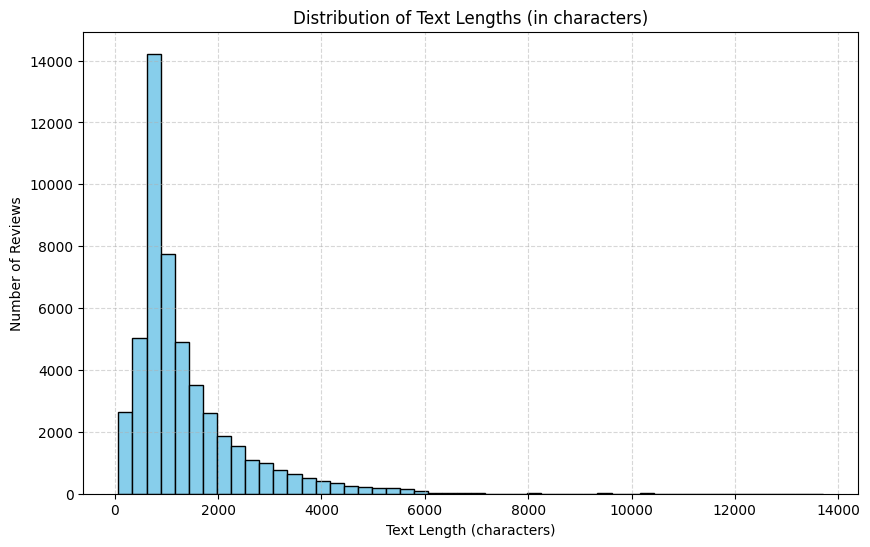

In [16]:
import matplotlib.pyplot as plt

def plot_text_length_distribution(texts: list[str]) -> None:
    lengths = np.array([len(text) for text in texts])
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Text Lengths (in characters)')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Number of Reviews')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_text_length_distribution(all_texts)

In [17]:
def get_shortest_and_longest_reviews(texts: list[str], n: int = 5) -> tuple[list[str], list[str]]:
    """
    Returns the n shortest and n longest reviews from the given list of texts.
    
    Args:
        texts: List of text reviews
        n: Number of shortest and longest reviews to return
        
    Returns:
        tuple containing lists of shortest and longest reviews
    """
    # Create a list of (text, length) tuples
    text_lengths = [(text, len(text)) for text in texts]
    
    # Sort by length
    text_lengths.sort(key=lambda x: x[1])
    
    # Get n shortest and n longest
    shortest = [text for text, _ in text_lengths[:n]]
    longest = [text for text, _ in text_lengths[-n:]]
    
    return shortest, longest

# Get 5 shortest and 5 longest reviews
shortest_reviews, longest_reviews = get_shortest_and_longest_reviews(all_texts, 5)

# Display shortest reviews
print("5 SHORTEST REVIEWS:")
for i, review in enumerate(shortest_reviews, 1):
    print(f"\nShortest Review #{i} ({len(review)} characters):")
    print("-" * 50)
    print(review[:200] + "..." if len(review) > 200 else review)
    print("-" * 50)

# Display longest reviews
print("\n\n5 LONGEST REVIEWS:")
for i, review in enumerate(longest_reviews, 1):
    print(f"\nLongest Review #{i} ({len(review)} characters):")
    print("-" * 50)
    # Only show the beginning and end of very long reviews
    if len(review) > 400:
        print(review[:200] + "\n...\n" + review[-200:])
    else:
        print(review)
    print("-" * 50)


5 SHORTEST REVIEWS:

Shortest Review #1 (70 characters):
--------------------------------------------------
Adrian Pasdar is excellent is this film. He makes a fascinating woman.
--------------------------------------------------

Shortest Review #2 (70 characters):
--------------------------------------------------
Adrian Pasdar is excellent is this film. He makes a fascinating woman.
--------------------------------------------------

Shortest Review #3 (70 characters):
--------------------------------------------------
Adrian Pasdar is excellent is this film. He makes a fascinating woman.
--------------------------------------------------

Shortest Review #4 (70 characters):
--------------------------------------------------
Adrian Pasdar is excellent is this film. He makes a fascinating woman.
--------------------------------------------------

Shortest Review #5 (81 characters):
--------------------------------------------------
I don't know why I like this movie so well, but I ne

In [18]:
# Find and display non-alphanumeric characters in the reviews
def find_non_alphanumeric(texts: list[str]) -> dict[str, int]:
    """
    Finds all non-alphanumeric characters in the texts and counts their occurrences.
    
    Args:
        texts: List of text reviews
        
    Returns:
        Dictionary mapping non-alphanumeric characters to their occurrence counts
    """
    non_alphanumeric = {}
    
    for text in texts:
        for char in text:
            if not char.isalnum() and not char.isspace():
                non_alphanumeric[char] = non_alphanumeric.get(char, 0) + 1
    
    return non_alphanumeric

# Get non-alphanumeric characters and their counts
non_alphanumeric_chars = find_non_alphanumeric(all_texts)

# Sort by frequency (most common first)
sorted_chars = sorted(non_alphanumeric_chars.items(), key=lambda x: x[1], reverse=True)

# Display the results
print("NON-ALPHANUMERIC CHARACTERS (sorted by frequency):")
print("-" * 50)
for char, count in sorted_chars:
    print(f"'{char}': {count} occurrences")
print("-" * 50)

# Show some examples of reviews with special characters
print("\nEXAMPLES OF REVIEWS WITH SPECIAL CHARACTERS:")
for char, _ in sorted_chars:  # Take top 5 most common special chars
    for text in all_texts[:1000]:  # Search in first 1000 reviews for efficiency
        if char in text:
            print(f"\nReview containing '{char}':")
            print("-" * 50)
            # Find the position of the character and show context around it
            pos = text.find(char)
            start = max(0, pos - 50)
            end = min(len(text), pos + 50)
            context = text[start:end]
            # Highlight the character
            print(f"...{context.replace(char, f'[{char}]')}...")
            print("-" * 50)
            break  # Only show one example per character


NON-ALPHANUMERIC CHARACTERS (sorted by frequency):
--------------------------------------------------
'.': 638616 occurrences
',': 576996 occurrences
''': 254788 occurrences
'/': 210996 occurrences
'>': 197092 occurrences
'<': 196976 occurrences
'-': 130664 occurrences
'"': 126372 occurrences
')': 75456 occurrences
'(': 74432 occurrences
'!': 47276 occurrences
':': 19636 occurrences
'?': 18976 occurrences
';': 14496 occurrences
'*': 11328 occurrences
'&': 6464 occurrences
'`': 1788 occurrences
'_': 1240 occurrences
'=': 1232 occurrences
'$': 924 occurrences
'%': 768 occurrences
'#': 684 occurrences
'+': 592 occurrences
'´': 460 occurrences
'{': 304 occurrences
'}': 304 occurrences
'’': 288 occurrences
']': 240 occurrences
'~': 240 occurrences
'[': 212 occurrences
'¨': 184 occurrences
'–': 156 occurrences
'¡': 152 occurrences
'@': 144 occurrences
'“': 100 occurrences
'”': 96 occurrences
'»': 80 occurrences
'«': 72 occurrences
'£': 64 occurrences
'^': 60 occurrences
'¦': 56 occurrences
'

**Results:**


Here’s an analysis and categorization of the non-alphanumeric characters you listed, with explanations and examples for each group:

---

**Punctuation (Standard English)**
These are the most common and serve grammatical or stylistic purposes in English text.

- **Sentence-ending:**  
  - `.` (period), `!` (exclamation), `?` (question mark)
- **Pausing/Separating:**  
  - `,` (comma), `;` (semicolon), `:` (colon), `-` (hyphen), `–` (en dash), `—` (em dash)
- **Quotation/Dialogue:**  
  - `'` (apostrophe), `"` (double quote), `‘’` (curly single quotes), `“”` (curly double quotes)
- **Parenthetical/Grouping:**  
  - `(`, `)`, `[`, `]`, `{`, `}`
- **Other:**  
  - `/` (slash), `\\` (backslash), `|` (pipe), `*` (asterisk), `&` (ampersand), `#` (hash), `@` (at), `^` (caret), `_` (underscore), `+` (plus), `=` (equals), `%` (percent), `$` (dollar), `~` (tilde), `` ` `` (backtick)



**HTML/XML Markup**
Characters commonly found in HTML tags or entities, often due to the dataset containing raw web data.

- `<`, `>`, `/`  
  - Used for opening/closing tags: `<br />`, `<p>`, etc.
  - **Also used for the heart symbol "<3" : this should not be cleaned away !**

**Special/Extended ASCII and Unicode**
These include typographic symbols, currency, and accented characters, often from non-English text or encoding artifacts.

- **Accented/Foreign Letters:**  
  - `´`, `¨`, `¡`, `£`, `¤`, `®`, `°`, ``, `₤`, `¿`
- **Typographic/Formatting:**  
  - `…` (ellipsis), `·` (middle dot), `§` (section), `¦` (broken bar), `–` (en dash), `—` (em dash), `“”` (curly quotes), `‘’` (curly apostrophes), `«»` (guillemets)

**Mathematical/Technical Symbols**
Occasionally appear in reviews, especially in ratings or technical discussions.

- `*`, `+`, `=`, `%`, `#`, `^`, `|`, `/`, `\\`

**Currency and Miscellaneous**
- `$`, `£`, `₤` (currencies)
- `@` (email, social media handles)
- `~` (approximation, tilde)
- `°` (degree symbol)

**Rare/Unusual Characters**
- `¿`, `¡` (Spanish punctuation)
- `»`, `«` (French/Spanish quotes)
- `¤`, `®`, `¦`, `§`, `·`, `¨`, `…` (various typographic or currency symbols)

**Whitespace and Control Characters**
Not explicitly listed, but often present in text data (e.g., `\n`, `\t`, non-breaking space).


**NLP Implications**

- **Punctuation** is often removed or normalized in preprocessing, but apostrophes and hyphens may be important for meaning (e.g., “don’t”, “re-enter”).
- **HTML/XML** should be stripped or converted to plain text.
- **Encoding Artifacts** should be cleaned or normalized to avoid noise.
- **Special/Unicode** characters may need normalization, especially for multilingual data.
- **Currency and Technical Symbols** may be relevant for certain tasks (e.g., financial sentiment).

In [19]:
### Get html tags

import re
from collections import defaultdict

# Dictionary to track occurrences of HTML-like tags
html_tag_occurrences = defaultdict(int)
html_tag_examples = defaultdict(list)

# Find all potential HTML tags in the texts
for text in all_texts:
    # Find all occurrences of patterns that look like HTML tags
    potential_tags = re.findall(r'<[^>]+>', text)
    
    for tag in potential_tags:
        html_tag_occurrences[tag] += 1
        # Store up to 3 examples of context for each tag
        if len(html_tag_examples[tag]) < 3:
            # Get some context around the tag
            start_idx = max(0, text.find(tag) - 30)
            end_idx = min(len(text), text.find(tag) + len(tag) + 30)
            context = text[start_idx:end_idx]
            html_tag_examples[tag].append(context)

# Display the most common HTML-like tags and their examples
print("Most common HTML-like tags:")
for tag, count in sorted(html_tag_occurrences.items(), key=lambda x: x[1], reverse=True)[:500]:
    print(f"{tag}: {count} occurrences")
    print("Examples:")
    for example in html_tag_examples[tag]:
        print(f"  - ...{example}...")
    print()

# Also check for individual < and > characters that might not be part of tags
less_than_count = sum('<' in text for text in all_texts)
greater_than_count = sum('>' in text for text in all_texts)

print(f"Total texts with '<' character: {less_than_count}")
print(f"Total texts with '>' character: {greater_than_count}")



Most common HTML-like tags:
<br />: 196928 occurrences
Examples:
  - ...een given a NAMBLA membership.<br /><br />Based upon Thomas Rockwe...
  - ...een given a NAMBLA membership.<br /><br />Based upon Thomas Rockwe...
  - ...een given a NAMBLA membership.<br /><br />Based upon Thomas Rockwe...

<3 <br />: 4 occurrences
Examples:
  - ... watch it. I LUVED IT SO MUCH <3 <br /><br />its about a women by the...
  - ... watch it. I LUVED IT SO MUCH <3 <br /><br />its about a women by the...
  - ... watch it. I LUVED IT SO MUCH <3 <br /><br />its about a women by the...

<SPOILER>: 4 occurrences
Examples:
  - ...ding is especially ridiculous <SPOILER>, as Kevin Bacon keeps coming ...
  - ...ding is especially ridiculous <SPOILER>, as Kevin Bacon keeps coming ...
  - ...ding is especially ridiculous <SPOILER>, as Kevin Bacon keeps coming ...

</SPOILER>: 4 occurrences
Examples:
  - ...of the word) have killed him. </SPOILER>. And the entire thing is quit...
  - ...of the word) have killed hi

In [20]:
def clean_html_tags(text: str) -> str:
    """
    Remove HTML tags from text while preserving the content between tags.
    Special case: preserves "<3" (heart symbol).
    
    Args:
        text: The input text containing potential HTML tags
        
    Returns:
        Text with HTML tags removed but content preserved
    """
    import re
    
    # First, temporarily replace "<3" with a special marker
    text = text.replace("<3", "HEART_SYMBOL_PLACEHOLDER")
    
    # Remove HTML tags
    cleaned_text = re.sub(r'<[^>]*>', '', text)
    
    # Restore the heart symbols
    cleaned_text = cleaned_text.replace("HEART_SYMBOL_PLACEHOLDER", "<3")
    
    return cleaned_text

# Test basic HTML tag removal
assert clean_html_tags("<p>Hello world</p>") == "Hello world"

# Test nested tags
assert clean_html_tags("<div><p>Nested content</p></div>") == "Nested content"

# Test with attributes
assert clean_html_tags('<a href="https://example.com">Link text</a>') == "Link text"

# Test with multiple tags and text
assert clean_html_tags("<h1>Title</h1><p>Paragraph</p>") == "TitleParagraph"

# Test with the special case of "<3" (heart symbol)
assert clean_html_tags("I LUVED IT SO MUCH <3 <br /><br />its about a women...<br /><br /> her<br /><br />") == "I LUVED IT SO MUCH <3 its about a women... her"

# Test with mixed content
assert clean_html_tags("Text with <b>bold</b> and <i>italic</i>") == "Text with bold and italic"

# Test with "<em>"
assert clean_html_tags("<em>This is emphasized</em>") == "This is emphasized"

# Test with </SPOILER>
assert clean_html_tags("</SPOILER>This is a spoiler</SPOILER>") == "This is a spoiler"

# Test with empty tags
assert clean_html_tags("<br><hr>Text") == "Text"

# Test with no tags
assert clean_html_tags("Plain text without tags") == "Plain text without tags"

assert any("<3" in text for text in all_texts) # check that the heart symbol is still in the text

In [21]:
all_texts = [clean_html_tags(text) for text in all_texts]

assert any("<3" in text for text in all_texts) # check that the heart symbol is still in the text

In [22]:
# What to do with each non-alphanumerical character ?
# ' ' ->

CHAR_MAP = {
    "%": " ",  # -> replace it with a space (will be tokenized later)
    "´": "'",  # -> Unify apostrophes. Apostrophes are important in words like "don't"
    ")": " ",
    "}": " ",
    "-": " ", 
    "/": " ",
    "$": " ",
    "_": " ", # in the dataset, it's used to make text in italics, so we remove it since that's only formatting
    "£": " ",
    "\\": " ",
    "'": "'",
    "“": " ",
    "~": " ",
    "¦": " ",
    "»": " ",
    "^": " ",
    "¨": " ",
    "(": " ",
    "”": " ",
    "|": " ",
    "’": "'",
    ".": " ",
    "[": " ",
    "°": " ",
    "¡": " ",
    "·": " ",
    "!": " ",
    "+": " ",
    "¤": " ",
    "¿": " ",
    ";": " ",
    "{": " ",
    '"': " ",
    "?": " ",
    "<": " ",
    ">": " ",
    "–": " ",
    "®": " ",
    "*": " ",
    "=": " ",
    "#": " ",
    "]": " ",
    "…": " ",
    ":": " ",
    ",": " ",
    "&": " ",
    "₤": " ",
    "‘": "'",
    "§": " ",
    "`": " ",
    "@": " ",
    "«": " ",
}


def get_rid_of_non_alphanumeric_characters(text: str, char_map: dict[str, str]) -> str:
    """
    Remove non-alphanumeric characters from text based on the provided character map.

    Args:
        text: The input text to clean
        char_map: A dictionary mapping characters to their replacements. If the replacement is None, the character will be kept as is.

    Returns:
        Text with non-alphanumeric characters replaced as specified in the character map.
    """

    for char, replacement in char_map.items():
        if replacement is None:
            continue  # keep the character as is
        else:
            text = text.replace(char, replacement)

    return text


assert get_rid_of_non_alphanumeric_characters("Hello world", CHAR_MAP) == "Hello world"
assert (
    get_rid_of_non_alphanumeric_characters("Hello @ world", CHAR_MAP) == "Hello   world"
)
assert (
    get_rid_of_non_alphanumeric_characters(
        "only £300 000 and 7 weeks to write", CHAR_MAP
    )
    == "only  300 000 and 7 weeks to write"
)


all_texts = [
    get_rid_of_non_alphanumeric_characters(text, CHAR_MAP) for text in all_texts
]



print("Remaining non-alphanumeric characters:")
find_non_alphanumeric(all_texts)

Remaining non-alphanumeric characters:


{"'": 255548}

### Lowercase the text

In [24]:
all_texts = [text.lower() for text in all_texts]

### Tokenize text

Since we already replaced all unwanted and punctuation characters with spaces, we only need to split by spaces ! 

In [38]:
from collections import Counter

tokens_counter: Counter[str] = Counter(t for text in all_texts for t in text.split())

# Get the 15 most common tokens
most_common_tokens = tokens_counter.most_common(15)
print("15 most common tokens:")
for token, _ in most_common_tokens:
    print(token)

# Get the 15 least common tokens
least_common_tokens = tokens_counter.most_common()[:-16:-1]
print("\n15 least common tokens:")
for token, _ in least_common_tokens:
    print(token)


15 most common tokens:
the
and
a
of
to
is
in
it
i
this
that
as
with
for
was

15 least common tokens:
amazon's
jayden
imy
ant1
nikolaidis
prousalis
athinodoros
haralambopoulos
vassilis
'guilty'
kavogianni
konstadinou
ketty
objectifier
rêves


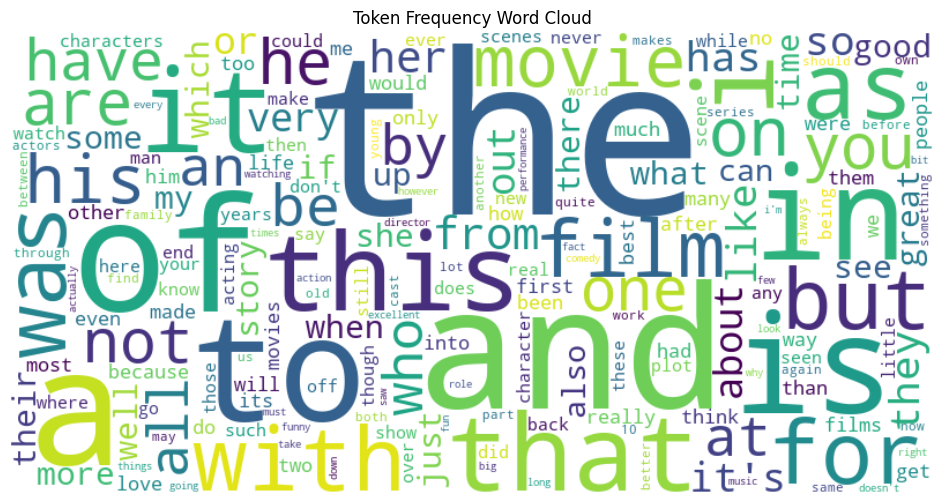

In [34]:
from wordcloud import WordCloud

def plot_wordcloud(tokens_counts: Counter[str]) -> None:
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(tokens_counts)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Token Frequency Word Cloud')
    plt.show()

plot_wordcloud(tokens_counter)


--- Threshold: 0.5% ---
Total unique tokens: 64169
Removing top 0.5% (320) most frequent tokens
Tokens remaining after filtering: 63849
Original total token count: 11826720
Filtered total token count: 4335924
Percentage of tokens removed: 63.34%
Sample of removed tokens (top 5):
'the' (count: 691960)
'and' (count: 358912)
'a' (count: 334688)
'of' (count: 307368)
'to' (count: 266920)

--- Threshold: 1% ---
Total unique tokens: 64169
Removing top 1% (641) most frequent tokens
Tokens remaining after filtering: 63528
Original total token count: 11826720
Filtered total token count: 3463468
Percentage of tokens removed: 70.71%
Sample of removed tokens (top 5):
'the' (count: 691960)
'and' (count: 358912)
'a' (count: 334688)
'of' (count: 307368)
'to' (count: 266920)

--- Threshold: 5% ---
Total unique tokens: 64169
Removing top 5% (3208) most frequent tokens
Tokens remaining after filtering: 60961
Original total token count: 11826720
Filtered total token count: 1634700
Percentage of tokens re

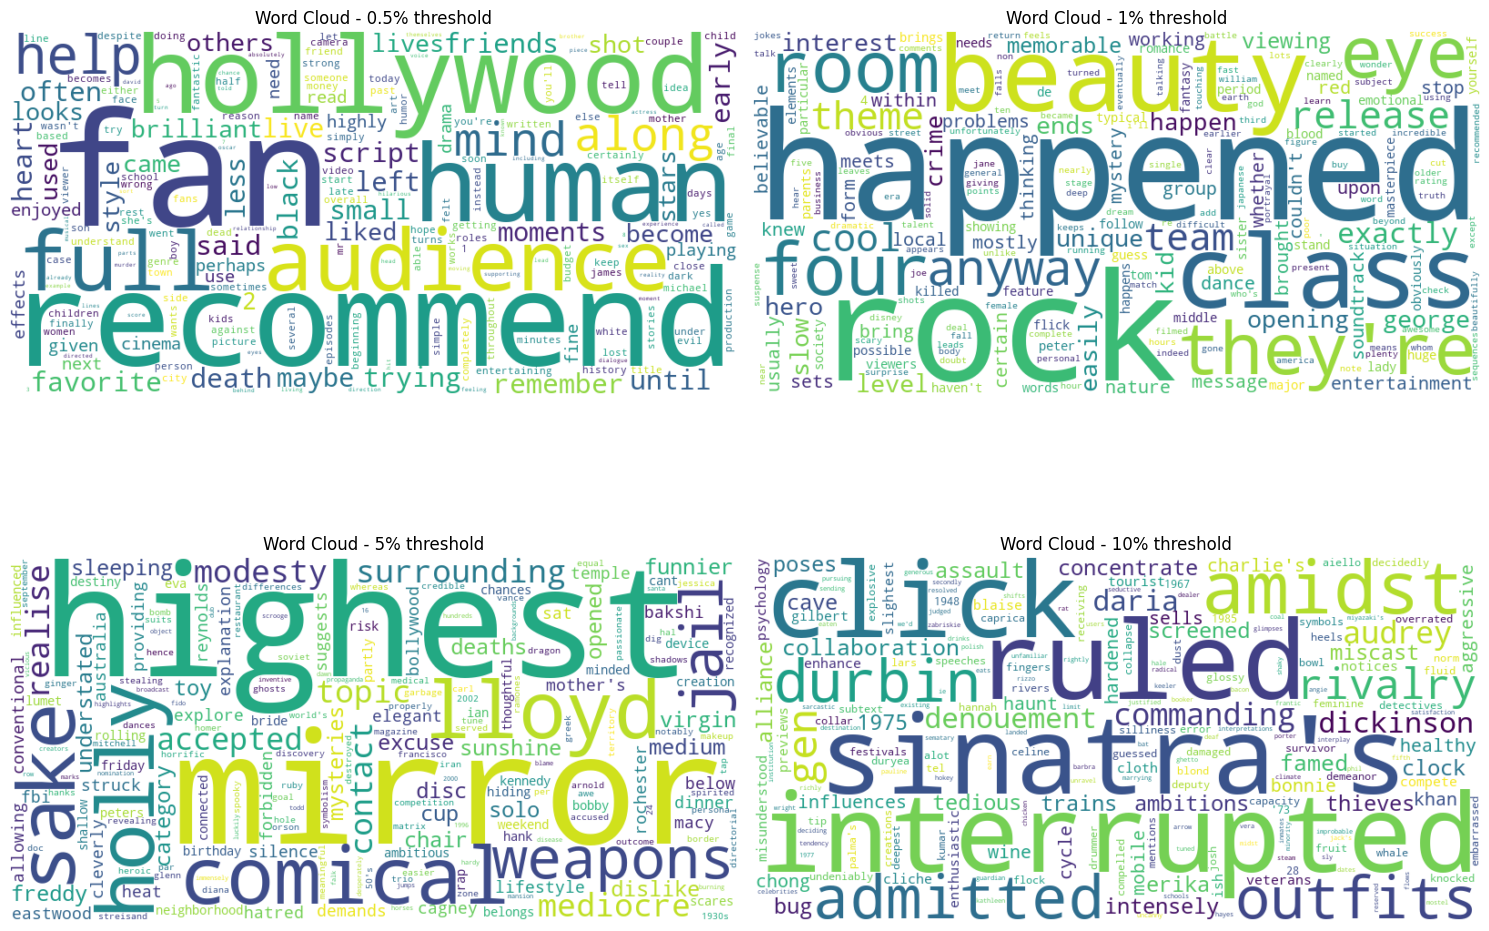

In [54]:
# Define different threshold percentages for removing most frequent tokens
threshold_percentages = [0.5, 1, 5, 10]  # Remove top X% most frequent tokens

# Create a figure with subplots for each threshold
plt.figure(figsize=(15, 12))

for i, THRESHOLD_PERCENTAGE in enumerate(threshold_percentages, 1):
    # Calculate how many tokens to remove
    total_unique_tokens = len(tokens_counter)
    tokens_to_remove = int(total_unique_tokens * THRESHOLD_PERCENTAGE / 100)
    
    print(f"\n--- Threshold: {THRESHOLD_PERCENTAGE}% ---")
    print(f"Total unique tokens: {total_unique_tokens}")
    print(f"Removing top {THRESHOLD_PERCENTAGE}% ({tokens_to_remove}) most frequent tokens")
    
    # Get the tokens to remove (the most frequent ones)
    tokens_to_remove_list = [token for token, _ in tokens_counter.most_common(tokens_to_remove)]
    
    # Create a new counter without the removed tokens
    filtered_tokens_counter = Counter({token: count for token, count in tokens_counter.items() 
                                      if token not in tokens_to_remove_list})
    
    print(f"Tokens remaining after filtering: {len(filtered_tokens_counter)}")
    
    # Compare the original and filtered token counts
    print(f"Original total token count: {sum(tokens_counter.values())}")
    print(f"Filtered total token count: {sum(filtered_tokens_counter.values())}")
    print(f"Percentage of tokens removed: {(sum(tokens_counter.values()) - sum(filtered_tokens_counter.values())) / sum(tokens_counter.values()) * 100:.2f}%")
    
    # Display some of the removed tokens
    print("Sample of removed tokens (top 5):")
    for token in tokens_to_remove_list[:5]:
        print(f"'{token}' (count: {tokens_counter[token]})")
    
    # Create a subplot for this threshold
    plt.subplot(2, 2, i)
    
    # Generate and display wordcloud
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(filtered_tokens_counter)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {THRESHOLD_PERCENTAGE}% threshold')

plt.tight_layout()
plt.show()



In [53]:
# Display the most frequent tokens after filtering with 5% threshold (as an example)
THRESHOLD_PERCENTAGE = 0.5
tokens_to_remove = int(total_unique_tokens * THRESHOLD_PERCENTAGE / 100)
tokens_to_remove_list = [token for token, _ in tokens_counter.most_common(tokens_to_remove)]
filtered_tokens_counter = Counter({token: count for token, count in tokens_counter.items() 
                                  if token not in tokens_to_remove_list})

print("\nMost frequent tokens after filtering with 5% threshold (top 10):")
for token, count in filtered_tokens_counter.most_common(10):
    print(f"'{token}' (count: {count})")


Most frequent tokens after filtering with 5% threshold (top 10):
'fan' (count: 4012)
'recommend' (count: 3996)
'hollywood' (count: 3984)
'human' (count: 3980)
'audience' (count: 3976)
'full' (count: 3968)
'help' (count: 3964)
'along' (count: 3960)
'mind' (count: 3956)
'trying' (count: 3944)


In [ ]:
from nltk.stem.porter import *
from sklearn.ensemble import RandomForestClassifier
stemmer = PorterStemmer()

## Remove X percentage and build vocabulary 
Remove all the tokens that do not meet the requirements based on the exercise sheet and build the vocabulary. 

## Use Porter Stemmer for stemming

## Build the bag of words (BOW)
For building the matrix for the representation of bag of words use the previously built vocabulary and tokens for each review.

# Task 3: Comparing BOWs

1. Use the previous steps to build a bag of words with the training data in which the tokens that appear more than 1% are discarded. 
1. Compare your BOW with LIBSVM BOW. 

# Task 4: Train a Random Forest and test it


# Task 5: Markov chain
Tip: For memory optimization use sparse structures not a matrix mostrly filled with zeros

## Pre-process data
Read the data and using the previous built functions for the BOW representation create a list of words per each review

## Chain words
Identify all the possible pairs of words (w0, w1) in all the reviews

## Initialize the Markov's Chain

## Generate data

Here you could also try to generate words for the unlabeled part of the dataset. Try to meassure the quality of the model

## Theoretical Questions

### 1. Categorization of Tasks

Define whether Tasks 2, 4, and 5 fall under NLG, NLU, or NLP.

### 2. Text Processing Pipeline Discussion

Discuss the advantages and drawbacks of steps like stemming and punctuation removal.

### 3. Review Linguistic Concepts

Define:

- Polysemy
- Zeugma
- Homonyms
- Homographs
- Homophones

Then answer:

- Are these concepts important in NLP? Why?
- How do they impact a BoW representation?

### 4. Markov Model Performance

Think about the performance of the Markov model, is it good? Why or why not?